# Shapley Tests

In [2]:
# %% Setup
# Imports
# Type imports
from typing import Any, Dict, Tuple

# Standard Libraries
#from pathlib import Path
from math import sqrt, pi, sin, cos, tan, radians
from statistics import mean
from itertools import zip_longest

# Shared Packages
import numpy as np
import pandas as pd
import xlwings as xw
#import PySimpleGUI as sg
#import pydicom
from shapely.geometry import Polygon
import shapely

# Global Settings
PRECISION = 3


In [3]:
def circle_points(radius: float, offset_x: float = 0, offset_y: float = 0,
                  num_points: int = 16, precision=3)->list[tuple[float, float]]:
    deg_step = radians(360/num_points)
    degree_points = np.arange(stop=radians(360), step=deg_step)
    x_coord = np.array([round(radius*sin(d), precision) for d in degree_points])
    y_coord = np.array([round(radius*cos(d), precision) for d in degree_points])

    x_coord = x_coord + offset_x
    y_coord = y_coord + offset_y
    coords = [(x,y) for x,y in zip(x_coord,y_coord)]
    return coords

In [4]:
def box_points(width:float, height: float = None, offset_x: float = 0,
               offset_y: float = 0) -> list[tuple[float, float]]:
    x1_unit = width / 2
    if not height:
        y1_unit = x1_unit
    else:
        y1_unit = height / 2
    coords = [
        ( x1_unit + offset_x,  y1_unit + offset_y),
        ( x1_unit + offset_x, -y1_unit + offset_y),
        (-x1_unit + offset_x, -y1_unit + offset_y),
        (-x1_unit + offset_x,  y1_unit + offset_y)
        ]
    return coords

### Equals

2FFF1FFF2


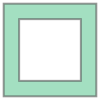

In [18]:
box6 = Polygon(box_points(6))
box4 = Polygon(box_points(4))
hollow_box = shapely.difference(box6, box4)
print(shapely.relate(hollow_box, hollow_box))
hollow_box

### Simple overlap

212111212


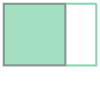

In [19]:
box6 = Polygon(box_points(6))
offset_box6 = Polygon(box_points(6,offset_x=3))
print(shapely.relate(box6, offset_box6))

shapely.union(box6, offset_box6.boundary)

212101212


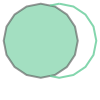

In [20]:
circle_6 = Polygon(circle_points(6))
offset_circle_6 = Polygon(circle_points(6,offset_x=3))
print(shapely.relate(circle_6, offset_circle_6))

shapely.union(circle_6, offset_circle_6.boundary)

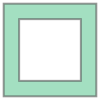

In [6]:
box6_right = Polygon(box_points(6, offset_x=6))
box4_right = Polygon(box_points(4, offset_x=6))
hollow_box_right = shapely.difference(box6_right, box4_right)
hollow_box_right

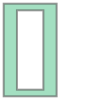

In [7]:
box4_inside = Polygon(box_points(2, 3.5, offset_x=-1))
box2_inside = Polygon(box_points(1, 3, offset_x=-1))
hollow_box_inside = shapely.difference(box4_inside, box2_inside)
hollow_box_inside

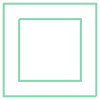

In [8]:
hollow_box.boundary

In [9]:
shapely.relate(hollow_box, hollow_box_right)

'FF2F11212'

FF2F11212


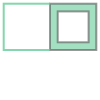

In [10]:
shape = Polygon(hollow_box.exterior)
print(shapely.relate(shape, hollow_box_right))
shapely.union(hollow_box.exterior, hollow_box_right)


FF2FF1212


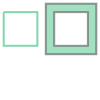

In [11]:
shape = Polygon(hollow_box.interiors[0])
print(shapely.relate(shape, hollow_box_right))
shapely.union(hollow_box.interiors[0], hollow_box_right)


212F11FF2


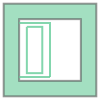

In [12]:
shape = Polygon(hollow_box.interiors[0])
print(shapely.relate(shape, hollow_box_inside))
shapely.union(hollow_box, hollow_box_inside.boundary)


FF2F112F2
212F1FFF2


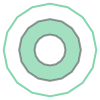

In [16]:
circle_6 = Polygon(circle_points(6))
circle_4 = Polygon(circle_points(4))
circle_2 = Polygon(circle_points(2))
island_shape = shapely.union(shapely.difference(circle_6, circle_4),circle_2)
island_border = shapely.difference(circle_4, circle_2)

print(shapely.relate(island_shape, island_border))

interior = Polygon(island_shape.geoms[0].interiors[0])
print(shapely.relate(interior, island_border))
shapely.union(island_shape.boundary, island_border)

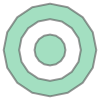

In [ ]:
circle_6 = Polygon(circle_points(6))
circle_4 = Polygon(circle_points(4))
circle_2 = Polygon(circle_points(2))
island = shapely.union(shapely.difference(circle_6, circle_4),circle_2)
island

In [49]:
offset_circle_6 = Polygon(circle_points(6,offset_x=6))
offset_circle_4 = Polygon(circle_points(4,offset_x=6))
offset_circle_2 = Polygon(circle_points(2,offset_x=6))
offset_island = shapely.union(shapely.difference(offset_circle_6, offset_circle_4),offset_circle_2)


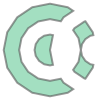

In [50]:
shapely.difference(island, offset_island)

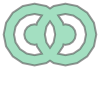

In [51]:
shapely.union(island, offset_island)

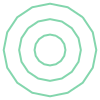

In [56]:
offset_island.boundary

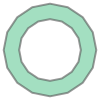

In [58]:
a = [g for g in offset_island.geoms]
a[0]

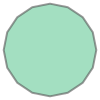

In [59]:
a[1]

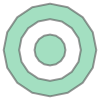

In [62]:
island

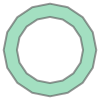

In [69]:
circle_35 = Polygon(circle_points(3.5))
circle_25 = Polygon(circle_points(2.5))
hollow = shapely.difference(circle_35, circle_25)
hollow

FF2FF1212


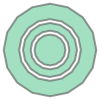

In [81]:
print(shapely.relate(island, hollow))
shapely.union(island, hollow)

212FF1FF2


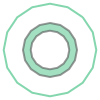

In [ ]:
shape = Polygon(island.geoms[0].exterior)
print(shapely.relate(shape, hollow))
shapely.union(island.geoms[0].exterior, hollow)


212FF1FF2


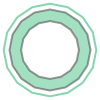

In [88]:
shape = Polygon(island.geoms[0].interiors[0])
print(shapely.relate(shape, hollow))
shapely.union(island.geoms[0].interiors[0], hollow)


FF2FF1212


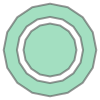

In [90]:
shape = Polygon(island.geoms[1])
print(shapely.relate(shape, hollow))
shapely.union(island.geoms[1], hollow)
